In [1]:
import os
import random
import shutil
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0, ResNet50
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input


import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import math

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from sklearn.metrics import confusion_matrix

In [2]:
# Define paths for your dataset splits
train_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/train"
val_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/val"
test_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/test"

In [37]:
# Define data augmentation for training data (you can modify these parameters)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize images to [0, 1] range
    rotation_range=30,           # Random rotation from -30 to +30 degrees
    width_shift_range=0.2,       # Random horizontal shift (20% of the image width)
    height_shift_range=0.2,      # Random vertical shift (20% of the image height)
    shear_range=0.2,             # Random shear transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest', 
    )

# For validation and test,  just rescale images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define paths for your dataset splits
train_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/train"
val_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/val"
test_dir = "/Users/rajendarbore/Downloads/Yamini Project/PokemonDataSplits/test"

# Create generators for the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical', 
    shuffle=True             
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical',
    shuffle=True           
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  
    batch_size=32,          
    class_mode='categorical',
    shuffle=False            
)

print("Data Augmentation setup complete!")


Found 1402 images belonging to 38 classes.
Found 301 images belonging to 38 classes.
Found 301 images belonging to 38 classes.
Data Augmentation setup complete!


In [29]:
# Load the MobileNetV2 model (pre-trained)
base_model_V2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model_V2.trainable = True
fine_tune_at = len(base_model_V2.layers) - 60  # Unfreeze last 40 layers
for layer in base_model_V2.layers[:fine_tune_at]:
    layer.trainable = False

# Define the model
model_V2 = models.Sequential([
    base_model_V2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')  
])

model_V2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_V2.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,054,950 (11.65 MB)

 Trainable params: 2,752,678 (10.50 MB)

 Non-trainable params: 302,272 (1.15 MB)

In [5]:

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("MobileNetV2.keras", monitor="val_loss", save_best_only=True)

# Train the model using the data generators
history_V2 = model_V2.fit(
    train_generator, 
    epochs=80,
    validation_data=val_generator,  
    callbacks=[early_stopping, model_checkpoint],
)

# Save the model
model_V2.save("MobileNetV2.keras")

# Save the training history
with open('MobileNetV2.pkl', 'wb') as f:
    pickle.dump(history_V2.history, f)

/Users/rajendarbore/Downloads/Yamini Project/PikachuVenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


2025-05-05 00:34:47.448265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.0334 - loss: 6.8137 - val_accuracy: 0.1030 - val_loss: 4.6465
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 979ms/step - accuracy: 0.0964 - loss: 5.7976 - val_accuracy: 0.2292 - val_loss: 4.0732
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1178 - loss: 5.4010 - val_accuracy: 0.3322 - val_loss: 3.5566
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1640 - loss: 5.0417 - val_accuracy: 0.4219 - val_loss: 3.2399
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 991ms/step - accuracy: 0.2208 - loss: 4.5985 - val_accuracy: 0.5050 - val_loss: 2.8812
Epoch 6/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3349 - loss: 3.8595 - val_accuracy: 0.5183 - val_loss: 2.8157
Epoch 7/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 996ms/step - accuracy: 0.3965 - loss: 3.5326 - val_accuracy: 0.5681 - val_loss: 2.6019
Epoch 8/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4288 - loss: 3.3381 - val_accuracy: 0.5980 - val_loss: 2

In [33]:
model_mob = tf.keras.models.load_model('MobileNetV2.keras')

# Load the training history of each model from the .pkl files
with open('MobileNetV2.pkl', 'rb') as f:
    history_mobilenetv2 = pickle.load(f)
    

In [40]:
test_loss, test_accuracy = model_mob.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.8975 - loss: 1.2944
Test Accuracy: 91.03%
Test Loss: 1.3008


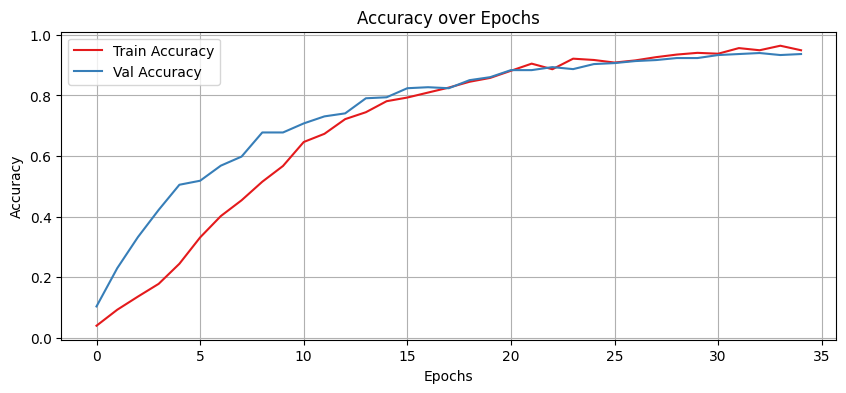

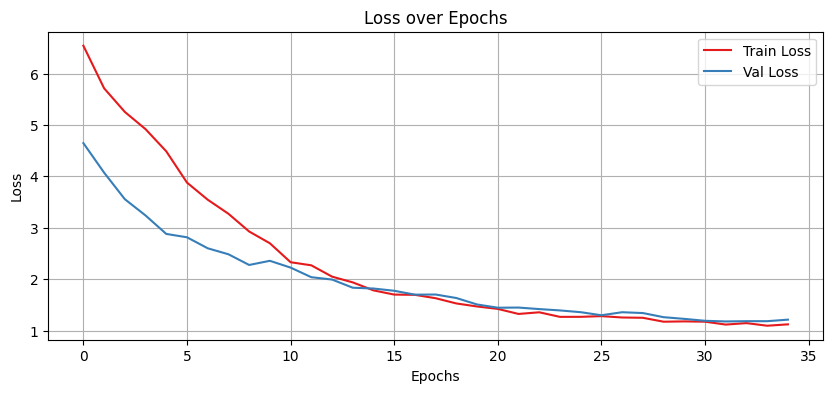

In [111]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_mobilenetv2['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history_mobilenetv2['loss'], label='Train Loss')
plt.plot(history_mobilenetv2['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get predictions on the test data
test_predictions = model_mob.predict(test_generator, verbose=1)
test_labels = test_generator.classes  # True labels of the test set

# Convert predictions to one-hot encoded (if not already)
predicted_labels = np.argmax(test_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.83      0.71      0.77         7
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       0.89      1.00      0.94         8
           5       1.00      0.86      0.92         7
           6       1.00      0.43      0.60         7
           7       0.88      0.88      0.88         8
           8       0.80      1.00      0.89         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      0.75      0.86         8
          12       0.88      1.00      0.93         7
          13       0.80      1.00      0.89         8
          14       0.70      0.88      0.78         8
          15       1.00      0.88      0.93         8
          16      

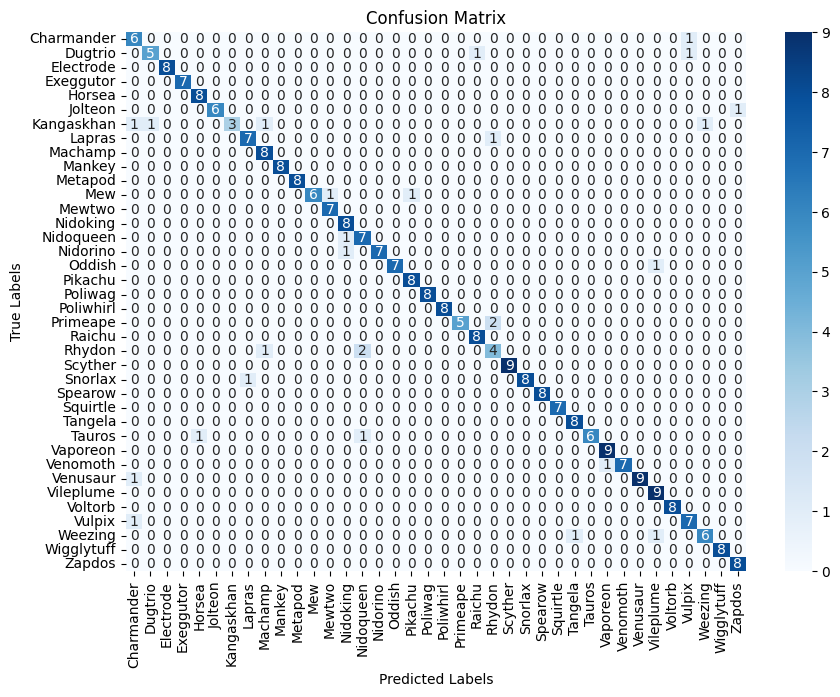

In [44]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


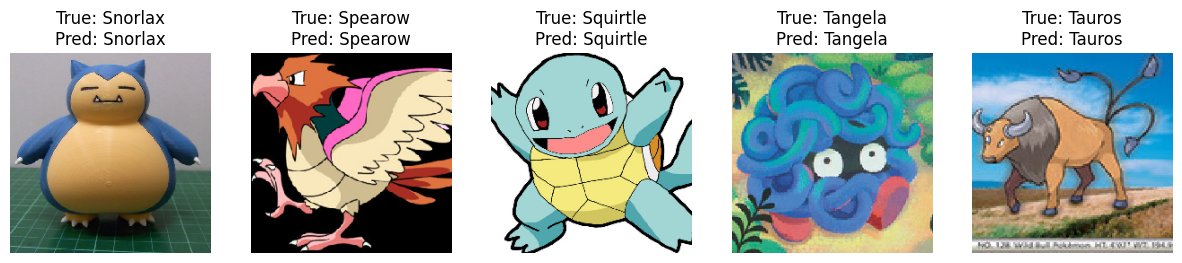

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

# plot true vs predicted labels with images
def plot_true_vs_predicted(model, dataset, num_images=5):
    # List to store selected images, true labels, and predicted labels
    selected_images = []
    selected_true_labels = []
    selected_predicted_labels = []

    # Get class names from the dataset
    class_names = list(dataset.class_indices.keys())

    # Set to track unique Pokémon classes for selection
    unique_pokemon = set()

    # Counter for how many unique images we've selected
    selected_count = 0

    # Iterate over the dataset and collect images
    for images, true_labels in dataset:
        if selected_count >= num_images:
            break

        # Iterate over each image in the batch
        for i in range(len(images)):
            # Check the class of the current image
            pokemon_class = np.argmax(true_labels[i])  # Find the index of the class

            # Skip if we've already selected this Pokémon class
            if pokemon_class not in unique_pokemon:
                unique_pokemon.add(pokemon_class)

                # Append the image, true label, and predicted label to the lists
                selected_images.append(images[i])
                selected_true_labels.append(np.argmax(true_labels[i]))  # Convert to integer class index

                # Make a prediction for the image
                prediction = model.predict(np.expand_dims(images[i], axis=0))  # Add batch dimension
                predicted_label = np.argmax(prediction, axis=1)[0]  # Get the predicted class label
                selected_predicted_labels.append(predicted_label)

                selected_count += 1

                # stop processing if enough images are selected
                if selected_count >= num_images:
                    break

    # Plot the images with true vs predicted labels
    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)

        # Rescale the image to [0, 1] to match the range expected by plt.imshow()
        image = selected_images[i]

        # If images are in the range [0, 255], divide by 255.0 (adjust if necessary based on your data)
        if image.max() > 1.0:
            image = image / 255.0

        # Display the image
        plt.imshow(image)

        true_label = class_names[selected_true_labels[i]]  # Get the true label (now integer index)
        predicted_label = class_names[selected_predicted_labels[i]]  # Get the predicted label
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis("off")  # Hide axis

    plt.show()

# Call the function with your model and dataset
plot_true_vs_predicted(model_mob, test_generator, num_images=5)  # Adjust dataset and num_images as needed


Class-wise AUCs:
  Charmander: AUC = 0.9985
  Dugtrio: AUC = 0.9990
  Electrode: AUC = 1.0000
  Exeggutor: AUC = 1.0000
  Horsea: AUC = 1.0000
  Jolteon: AUC = 1.0000
  Kangaskhan: AUC = 1.0000
  Lapras: AUC = 0.9987
  Machamp: AUC = 1.0000
  Mankey: AUC = 1.0000
  Metapod: AUC = 1.0000
  Mew: AUC = 0.9953
  Mewtwo: AUC = 1.0000
  Nidoking: AUC = 1.0000
  Nidoqueen: AUC = 0.9966
  Nidorino: AUC = 0.9996
  Oddish: AUC = 1.0000
  Pikachu: AUC = 1.0000
  Poliwag: AUC = 1.0000
  Poliwhirl: AUC = 1.0000
  Primeape: AUC = 0.9995
  Raichu: AUC = 1.0000
  Rhydon: AUC = 0.9951
  Scyther: AUC = 1.0000
  Snorlax: AUC = 1.0000
  Spearow: AUC = 1.0000
  Squirtle: AUC = 1.0000
  Tangela: AUC = 1.0000
  Tauros: AUC = 0.9979
  Vaporeon: AUC = 1.0000
  Venomoth: AUC = 0.9996
  Venusaur: AUC = 0.9928
  Vileplume: AUC = 0.9996
  Voltorb: AUC = 1.0000
  Vulpix: AUC = 0.9825
  Weezing: AUC = 0.9970
  Wigglytuff: AUC = 1.0000
  Zapdos: AUC = 1.0000

Macro-average AUC = 0.9990


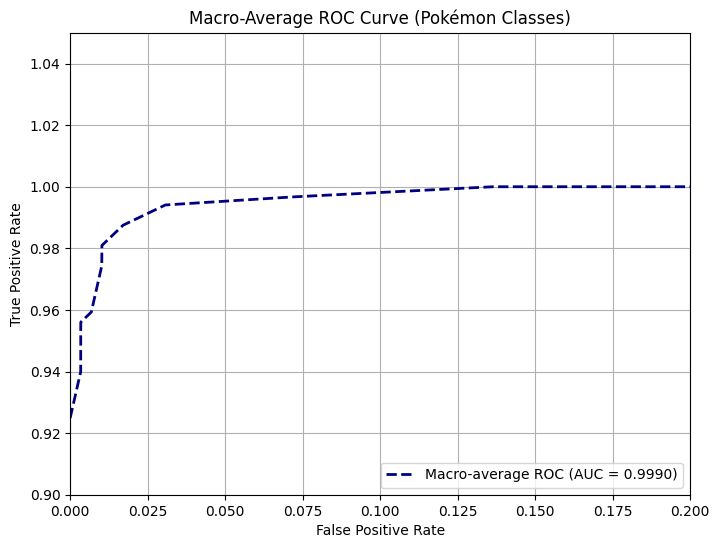

In [57]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Dynamically get class names from the generator
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# Binarize the test labels based on class indices
true_labels = label_binarize(test_labels, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Print class-wise AUCs with class names
print("Class-wise AUCs:")
for i, name in enumerate(class_names):
    print(f"  {name}: AUC = {roc_auc[i]:.4f}")
print(f"\nMacro-average AUC = {roc_auc['macro']:.4f}")

# Plot only the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
         label='Macro-average ROC (AUC = {:.4f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 0.2])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve (Pokémon Classes)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


# Define data augmentation for training data
train_datagen_B0 = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest', 
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)



# For validation and test, we just rescale images 
test_datagen_B0 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)
val_datagen_B0 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)

# Create generators for the datasets
train_generator_B0 = train_datagen_B0.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical', 
    shuffle=True            
)

val_generator_B0 = val_datagen_B0.flow_from_directory(
    val_dir,
    target_size=(224, 224),  
    batch_size=32,           
    class_mode='categorical',
    shuffle=False           
)

test_generator_B0= test_datagen_B0.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=32,           
    class_mode='categorical',
    shuffle=False           
)

print("Data Augmentation setup complete!")
 

Found 1402 images belonging to 38 classes.
Found 301 images belonging to 38 classes.
Found 301 images belonging to 38 classes.
Data Augmentation setup complete!


In [25]:

# Load EfficientNetB0 model pre-trained on ImageNet
base_model_B0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze all layers of the base model
base_model_B0.trainable = False

# Unfreeze top layers for additional training
fine_tune_at_B0 = len(base_model_B0.layers) - 60
base_model_B0.trainable = True

for layer in base_model_B0.layers[:fine_tune_at_B0]:
    layer.trainable = False  # Keep initial layers frozen
for layer in base_model_B0.layers[fine_tune_at_B0:]:
    layer.trainable = True  # Fine-tune last 60 layers


model_B0 = tf.keras.Sequential([
    base_model_B0,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(38, activation='softmax')  # 38 classes for Pokémon
])


# Compile the model
model_B0.compile(
    optimizer=Adam(learning_rate=0.00005),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_B0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,724,937 (18.02 MB)

 Trainable params: 3,347,430 (12.77 MB)

 Non-trainable params: 1,377,507 (5.25 MB)

In [5]:
# Define EarlyStopping
early_stopping_B0 = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define Learning Rate Scheduler (ReduceLROnPlateau)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by a factor of 0.5
    patience=2,  # Wait for 2 epochs with no improvement in validation loss
    min_lr=1e-7,  # Minimum learning rate (you can adjust this)
    verbose=1  # Print a message when the learning rate is reduced
)

# Train the model with fine-tuning and learning rate scheduler
history_B0 = model_B0.fit(
    train_generator_B0,
    epochs=45,
    validation_data=val_generator_B0,
    callbacks=[early_stopping_B0, lr_scheduler]  # Add the scheduler here
)

# Save the trained model
model_B0.save("EfficientNetB0_final.keras")

# Save training history
with open('EfficientNetB0_history.pkl', 'wb') as f:
    pickle.dump(history_B0.history, f)

/Users/rajendarbore/Downloads/Yamini Project/PikachuVenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45


2025-05-05 03:58:08.929600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.0319 - loss: 3.8557 - val_accuracy: 0.1229 - val_loss: 3.4179 - learning_rate: 5.0000e-05
Epoch 2/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1573 - loss: 3.2970 - val_accuracy: 0.3123 - val_loss: 2.8497 - learning_rate: 5.0000e-05
Epoch 3/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2890 - loss: 2.8927 - val_accuracy: 0.5316 - val_loss: 2.2377 - learning_rate: 5.0000e-05
Epoch 4/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4606 - loss: 2.4158 - val_accuracy: 0.6777 - val_loss: 1.6825 - learning_rate: 5.0000e-05
Epoch 5/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5779 - loss: 1.9382 - val_accuracy: 0.8040 - val_loss: 1.2607 - learning_rate: 5.0000e-05
Epoch 6/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6803 - loss: 1.5857 - val_accuracy: 0.8571 - val_loss: 0.9463 - learning_rate: 5.0000e-05
Epoch 7/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7387 - loss: 1.2779 -

In [32]:
model_eff = tf.keras.models.load_model('EfficientNetB0_final.keras')
with open('EfficientNetB0_history.pkl', 'rb') as f:
    history_B0 = pickle.load(f)

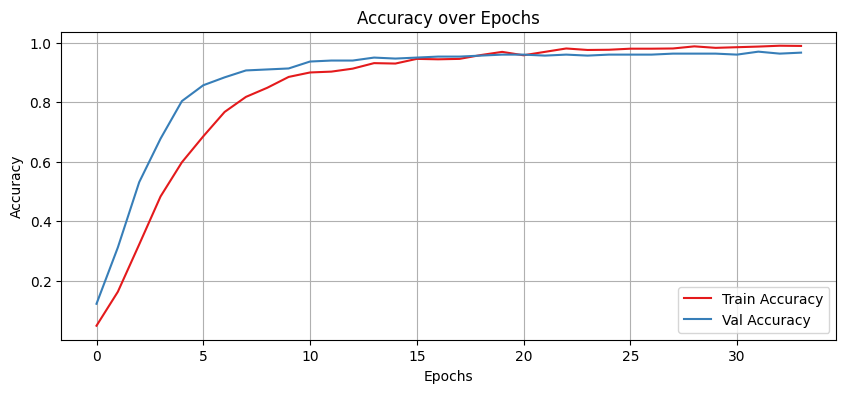

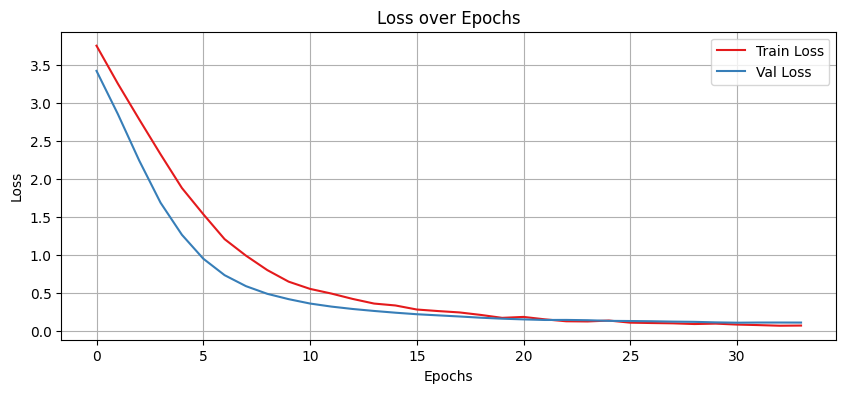

In [59]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_B0['accuracy'], label='Train Accuracy')
plt.plot(history_B0['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history_B0['loss'], label='Train Loss')
plt.plot(history_B0['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
test_loss, test_accuracy = model_eff.evaluate(test_generator_B0, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 946ms/step - accuracy: 0.9396 - loss: 0.1909
Test Accuracy: 94.02%
Test Loss: 0.1929


In [62]:
from sklearn.metrics import classification_report

# Get predictions on the test data
test_predictions_Bo = model_eff.predict(test_generator_B0, verbose=1)
test_labels_B0 = test_generator_B0.classes  # True labels of the test set

# Convert predictions to one-hot encoded (if not already)
predicted_labels_B0 = np.argmax(test_predictions_Bo, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_B0, predicted_labels_B0))


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         8
           5       1.00      0.86      0.92         7
           6       1.00      0.86      0.92         7
           7       0.86      0.75      0.80         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      0.75      0.86         8
          12       0.88      1.00      0.93         7
          13       1.00      1.00      1.00         8
          14       0.73      1.00      0.84         8
          15       0.80      1.00      0.89         8
          16     

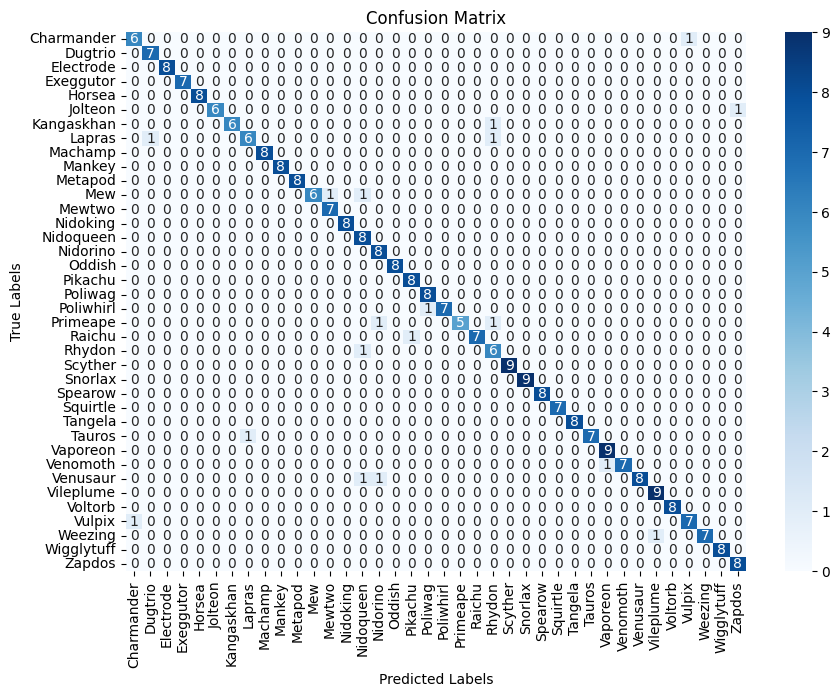

In [68]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_B0, predicted_labels_B0)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


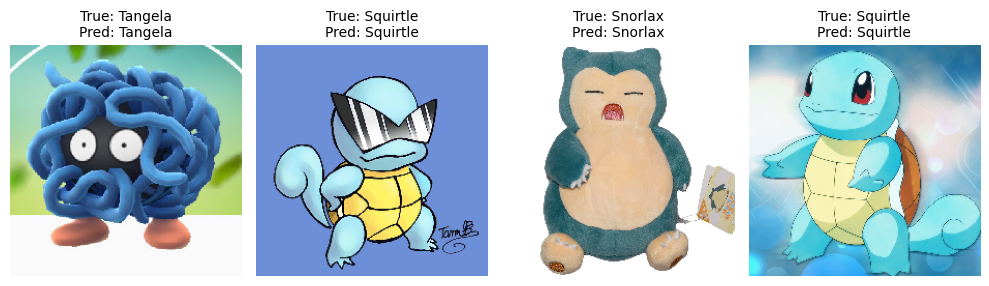

In [74]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the test generator
test_images, true_onehot = next(test_generator_B0)
true_labels_batch = np.argmax(true_onehot, axis=1)

# Predict using the model on that batch
pred_probs_batch = model_eff.predict(test_images)
pred_labels_batch = np.argmax(pred_probs_batch, axis=1)

# Class names list
class_names = list(test_generator_B0.class_indices.keys())

# Randomly select 4 indices from the batch
random_indices = random.sample(range(len(test_images)), 4)

# Plot the 4 randomly selected images with their true & predicted labels
plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 4, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))
    true_class = class_names[true_labels_batch[idx]]
    pred_class = class_names[pred_labels_batch[idx]]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


Class-wise AUCs:
  Charmander: AUC = 0.9995
  Dugtrio: AUC = 1.0000
  Electrode: AUC = 1.0000
  Exeggutor: AUC = 1.0000
  Horsea: AUC = 1.0000
  Jolteon: AUC = 1.0000
  Kangaskhan: AUC = 1.0000
  Lapras: AUC = 0.9962
  Machamp: AUC = 1.0000
  Mankey: AUC = 0.9996
  Metapod: AUC = 1.0000
  Mew: AUC = 0.9979
  Mewtwo: AUC = 0.9995
  Nidoking: AUC = 1.0000
  Nidoqueen: AUC = 0.9991
  Nidorino: AUC = 1.0000
  Oddish: AUC = 1.0000
  Pikachu: AUC = 1.0000
  Poliwag: AUC = 1.0000
  Poliwhirl: AUC = 1.0000
  Primeape: AUC = 0.9985
  Raichu: AUC = 1.0000
  Rhydon: AUC = 0.9976
  Scyther: AUC = 1.0000
  Snorlax: AUC = 1.0000
  Spearow: AUC = 1.0000
  Squirtle: AUC = 1.0000
  Tangela: AUC = 1.0000
  Tauros: AUC = 1.0000
  Vaporeon: AUC = 1.0000
  Venomoth: AUC = 1.0000
  Venusaur: AUC = 0.9890
  Vileplume: AUC = 1.0000
  Voltorb: AUC = 1.0000
  Vulpix: AUC = 0.9983
  Weezing: AUC = 0.9996
  Wigglytuff: AUC = 1.0000
  Zapdos: AUC = 1.0000

Macro-average AUC = 0.9995


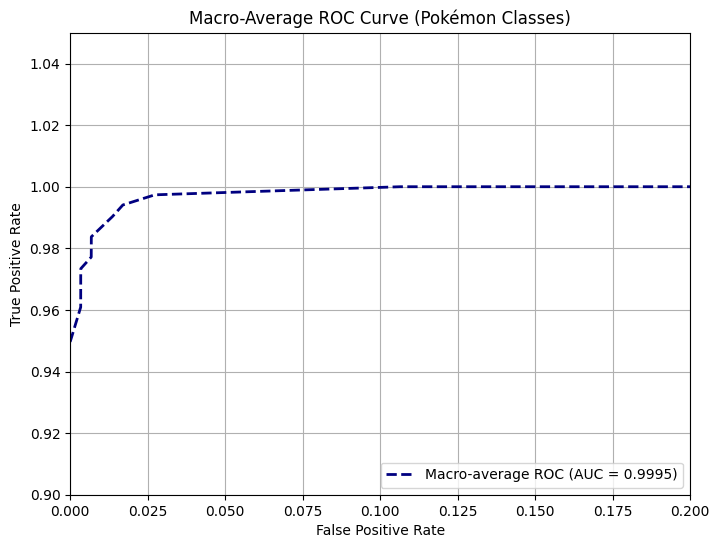

In [75]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Dynamically get class names from the generator
class_names = list(test_generator_B0.class_indices.keys())
num_classes = len(class_names)

# Binarize the test labels based on class indices
true_labels = label_binarize(test_labels_B0, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Print class-wise AUCs with class names
print("Class-wise AUCs:")
for i, name in enumerate(class_names):
    print(f"  {name}: AUC = {roc_auc[i]:.4f}")
print(f"\nMacro-average AUC = {roc_auc['macro']:.4f}")

# Plot only the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
         label='Macro-average ROC (AUC = {:.4f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 0.2])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve (Pokémon Classes)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define data augmentation for training data (you can modify these parameters)
train_datagen_50 = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Horizontally shift images by 20%
    height_shift_range=0.2,  # Vertically shift images by 20%
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill missing pixels after transformations
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)



# For validation and test, we just rescale images (no augmentation)
test_datagen_50= tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)
val_datagen_50= tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input  # Apply EfficientNetB0 preprocessing
)

# Create generators for the datasets
train_generator_50 = train_datagen_50.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 150x150 (adjust as needed)
    batch_size=32,           # Number of images to yield per batch
    class_mode='categorical', # Since it's a classification problem
    shuffle=True             # Shuffle data
)

val_generator_50= val_datagen_50.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize images to 150x150
    batch_size=32,           # Number of images to yield per batch
    class_mode='categorical',
    shuffle=False            # No shuffling for validation data
)

test_generator_50= test_datagen_50.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize images to 150x150
    batch_size=32,           # Number of images to yield per batch
    class_mode='categorical',
    shuffle=False            # No shuffling for test data
)


Found 1402 images belonging to 38 classes.
Found 301 images belonging to 38 classes.
Found 301 images belonging to 38 classes.


In [4]:
# Load ResNet50 model pre-trained on ImageNet
base_model_ResNet50 = ResNet50(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Freeze all layers of the base model
base_model_ResNet50.trainable = False

# Fine-Tuning: Unfreeze top layers for additional training
fine_tune_at_ResNet50 = len(base_model_ResNet50.layers) - 30     #-----------------
base_model_ResNet50.trainable = True
for layer in base_model_ResNet50.layers[:fine_tune_at_ResNet50]:
    layer.trainable = False  # Keep initial layers frozen
for layer in base_model_ResNet50.layers[fine_tune_at_ResNet50:]:
    layer.trainable = True  # Fine-tune last 60 layers

# Create custom classification head
model_ResNet50 = tf.keras.Sequential([
    base_model_ResNet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(38, activation='softmax')
])

# Compile the model
model_ResNet50.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning       ---------------
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_ResNet50.summary()

2025-05-05 22:30:23.157025: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-05 22:30:23.157204: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-05 22:30:23.157210: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-05 22:30:23.157442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 22:30:23.157462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,656,294 (94.06 MB)

 Trainable params: 15,518,758 (59.20 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [5]:

# Define EarlyStopping, ModelCheckpoint & Learning Rate Scheduler
early_stopping_ResNet50 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_ResNet50 = ModelCheckpoint("ResNet50.keras", save_best_only=True, monitor='val_loss', mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Train the model with fine-tuning
history_ResNet50 = model_ResNet50.fit(
    train_generator_50,
    epochs=30,
    validation_data=val_generator_50,
    callbacks=[early_stopping_ResNet50, checkpoint_ResNet50, lr_scheduler]
)

/Users/rajendarbore/Downloads/Yamini Project/PikachuVenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-05-05 22:30:51.666679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1025 - loss: 12.2382 - val_accuracy: 0.7176 - val_loss: 8.9622 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6526 - loss: 9.1654 - val_accuracy: 0.8738 - val_loss: 8.0193 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8649 - loss: 8.0885 - val_accuracy: 0.9402 - val_loss: 7.5309 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9267 - loss: 7.5545 - val_accuracy: 0.9402 - val_loss: 7.1917 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9737 - loss: 7.0677 - val_accuracy: 0.9701 - val_loss: 6.7953 - learning_rate: 1.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9733 - loss: 6.6949 - val_accuracy: 0.9535 - val_loss: 6.4661 - learning_rate: 1.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9839 - loss: 6.3075 - 

In [49]:
model_ResNet50.save("ResNet50Final.keras")

In [8]:
# Save training history
with open('ResNet50history.pkl', 'wb') as f:
    pickle.dump(history_ResNet50.history, f)

In [10]:
# Load history
with open('ResNet50history.pkl', 'rb') as f:
    history_resnet50 = pickle.load(f)

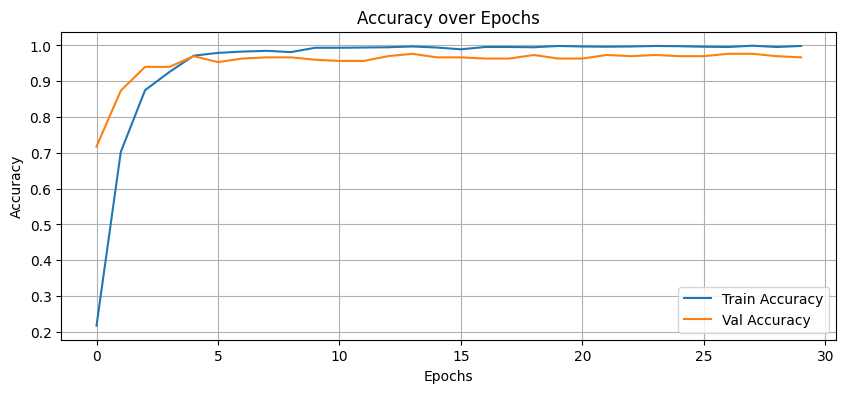

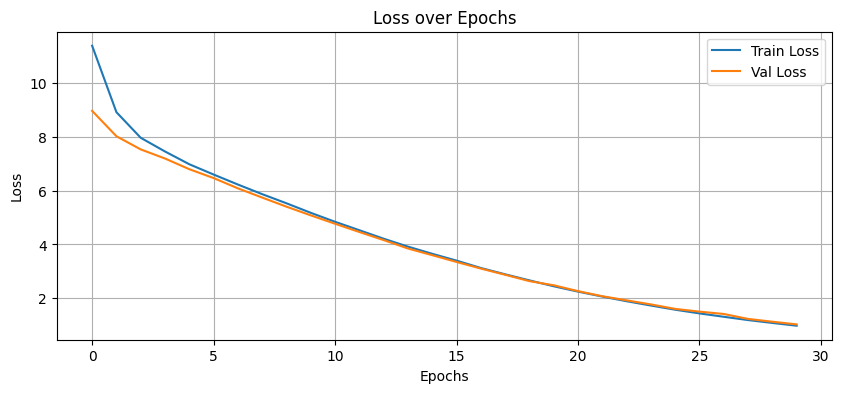

In [11]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_resnet50['accuracy'], label='Train Accuracy')
plt.plot(history_resnet50['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history_resnet50['loss'], label='Train Loss')
plt.plot(history_resnet50['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# Evaluate on test set
test_loss, test_accuracy = model_ResNet50.evaluate(test_generator_50, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - accuracy: 0.9627 - loss: 1.0333
Test Accuracy: 96.01%
Test Loss: 1.0372


In [14]:
from sklearn.metrics import classification_report

# Get predictions on the test data
test_predictions_50 = model_ResNet50.predict(test_generator_50, verbose=1)
test_labels_50 = test_generator_50.classes  # True labels of the test set

# Convert predictions to one-hot encoded (if not already)
predicted_labels_50 = np.argmax(test_predictions_50, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_50, predicted_labels_50))


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         8
           5       1.00      0.71      0.83         7
           6       1.00      1.00      1.00         7
           7       1.00      0.88      0.93         8
           8       0.80      1.00      0.89         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.86      0.92         7
          13       0.89      1.00      0.94         8
          14       1.00      0.88      0.93         8
          15       1.00      1.00      1.00         8
          16     

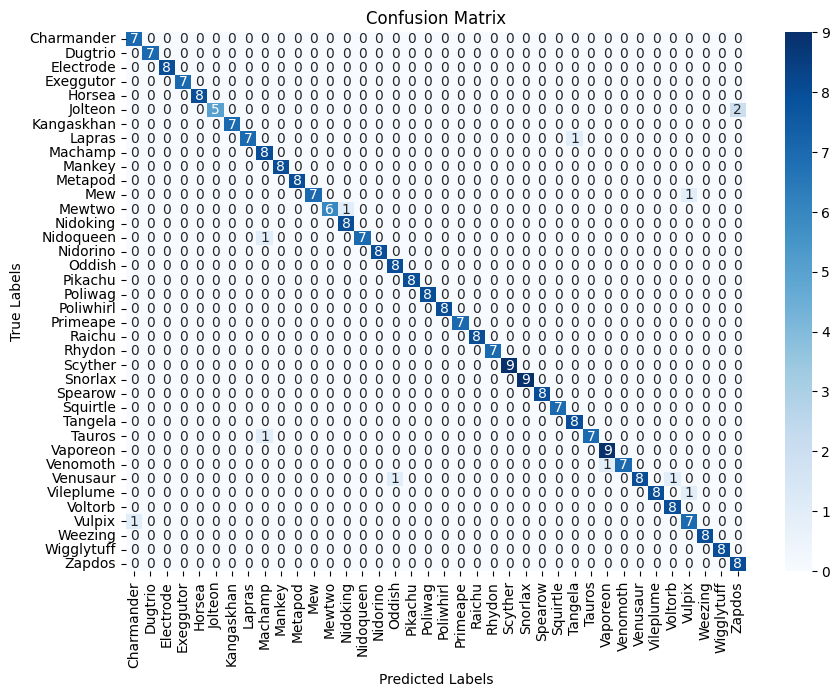

In [16]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_50, predicted_labels_50)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_50.class_indices.keys(), yticklabels=test_generator_50.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


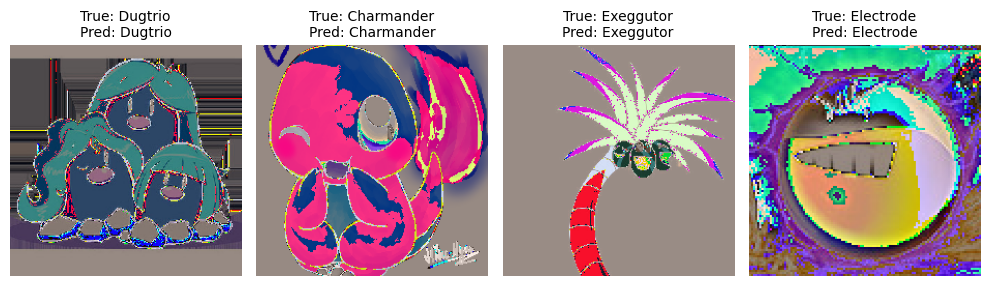

In [45]:
# Get a batch from the test generator
test_images, true_onehot = next(test_generator_50)
true_labels_batch = np.argmax(true_onehot, axis=1)

# Predict using the model on that batch
pred_probs_batch = model_ResNet50.predict(test_images)
pred_labels_batch = np.argmax(pred_probs_batch, axis=1)

# Class names list
class_names = list(test_generator_50.class_indices.keys())

# Randomly select 4 indices from the batch
random_indices = random.sample(range(len(test_images)), 4)

# Plot the 4 randomly selected images with their true & predicted labels
plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 4, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))
    true_class = class_names[true_labels_batch[idx]]
    pred_class = class_names[pred_labels_batch[idx]]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Get predictions on the test data
test_predictions = model_ResNet50.predict(test_generator_50, verbose=1)
test_labels = test_generator_50.classes  # True labels of the test set

# Convert predictions to class indices
predicted_labels = np.argmax(test_predictions, axis=1)

# Calculate macro-averaged Precision, Recall, and F1 Score
macro_precision = precision_score(test_labels, predicted_labels, average='macro')
macro_recall = recall_score(test_labels, predicted_labels, average='macro')
macro_f1 = f1_score(test_labels, predicted_labels, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step
Macro Precision: 0.9660
Macro Recall: 0.9608
Macro F1 Score: 0.9605


Class-wise AUCs:
  Charmander: AUC = 1.0000
  Dugtrio: AUC = 1.0000
  Electrode: AUC = 1.0000
  Exeggutor: AUC = 1.0000
  Horsea: AUC = 1.0000
  Jolteon: AUC = 0.9995
  Kangaskhan: AUC = 1.0000
  Lapras: AUC = 0.9991
  Machamp: AUC = 1.0000
  Mankey: AUC = 1.0000
  Metapod: AUC = 1.0000
  Mew: AUC = 1.0000
  Mewtwo: AUC = 1.0000
  Nidoking: AUC = 1.0000
  Nidoqueen: AUC = 0.9991
  Nidorino: AUC = 1.0000
  Oddish: AUC = 1.0000
  Pikachu: AUC = 1.0000
  Poliwag: AUC = 1.0000
  Poliwhirl: AUC = 1.0000
  Primeape: AUC = 1.0000
  Raichu: AUC = 1.0000
  Rhydon: AUC = 1.0000
  Scyther: AUC = 1.0000
  Snorlax: AUC = 1.0000
  Spearow: AUC = 1.0000
  Squirtle: AUC = 1.0000
  Tangela: AUC = 1.0000
  Tauros: AUC = 0.9987
  Vaporeon: AUC = 1.0000
  Venomoth: AUC = 1.0000
  Venusaur: AUC = 1.0000
  Vileplume: AUC = 1.0000
  Voltorb: AUC = 1.0000
  Vulpix: AUC = 0.9991
  Weezing: AUC = 1.0000
  Wigglytuff: AUC = 1.0000
  Zapdos: AUC = 1.0000

Macro-average AUC = 0.9999


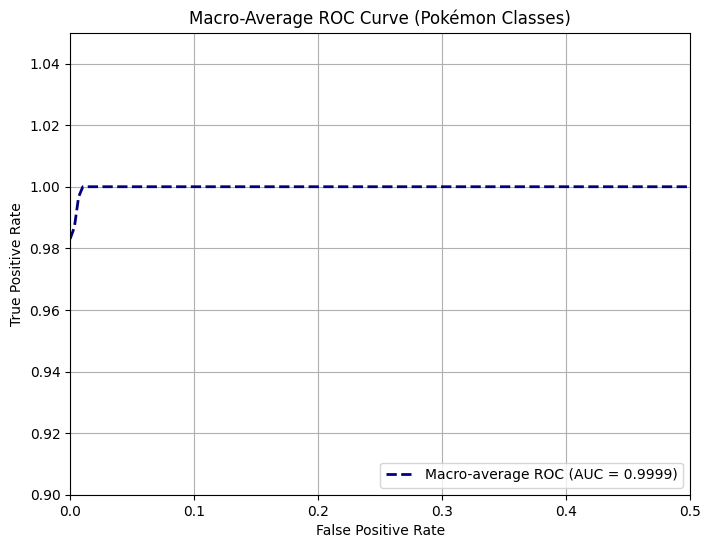

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Dynamically get class names from the generator
class_names = list(test_generator_50.class_indices.keys())
num_classes = len(class_names)

# Binarize the test labels based on class indices
true_labels = label_binarize(test_labels_50, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Print class-wise AUCs with class names
print("Class-wise AUCs:")
for i, name in enumerate(class_names):
    print(f"  {name}: AUC = {roc_auc[i]:.4f}")
print(f"\nMacro-average AUC = {roc_auc['macro']:.4f}")

# Plot only the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
         label='Macro-average ROC (AUC = {:.4f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 0.5])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve (Pokémon Classes)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


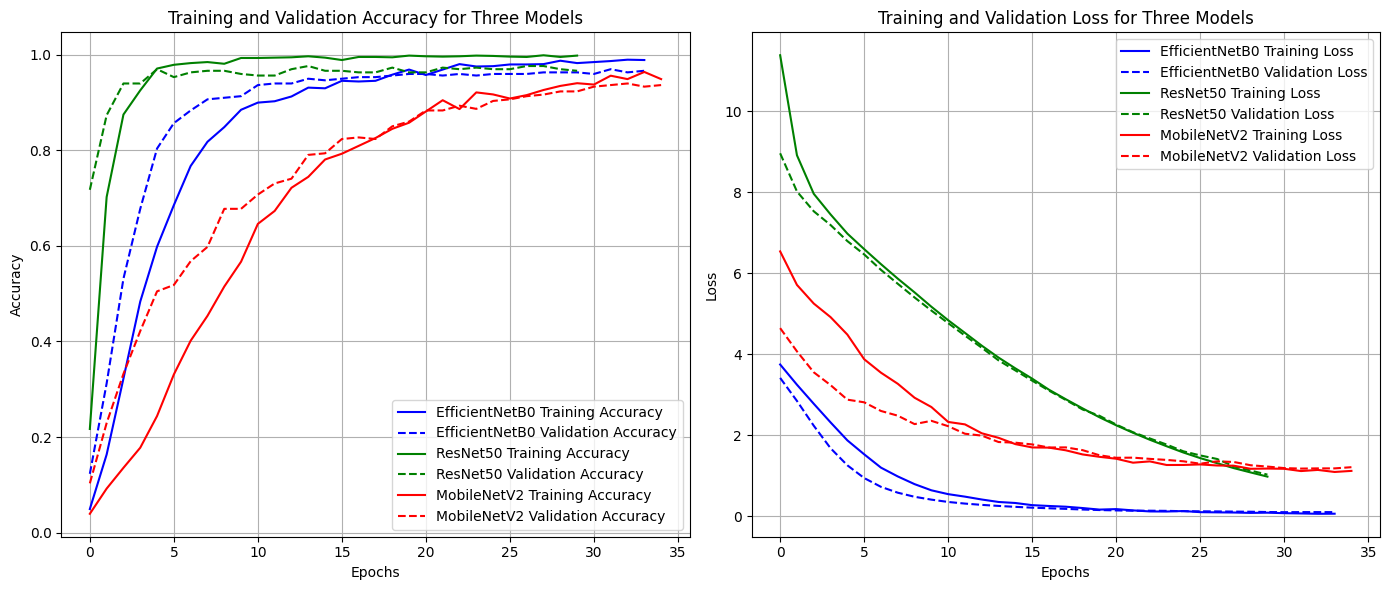

In [34]:
# Extract accuracy and loss for each model
# For EfficientNetB0
train_acc_B0 = history_B0['accuracy']
val_acc_B0 = history_B0['val_accuracy']
train_loss_B0 = history_B0['loss']
val_loss_B0 = history_B0['val_loss']

# For ResNet50
train_acc_resnet50 = history_resnet50['accuracy']
val_acc_resnet50 = history_resnet50['val_accuracy']
train_loss_resnet50 = history_resnet50['loss']
val_loss_resnet50 = history_resnet50['val_loss']

# For MobileNetV2
train_acc_mobilenetv2 = history_mobilenetv2['accuracy']
val_acc_mobilenetv2 = history_mobilenetv2['val_accuracy']
train_loss_mobilenetv2 = history_mobilenetv2['loss']
val_loss_mobilenetv2 = history_mobilenetv2['val_loss']

# Create a figure with two subplots: one for accuracy, one for loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Training and Validation Accuracy
ax1.plot(train_acc_B0, label='EfficientNetB0 Training Accuracy', color='blue')
ax1.plot(val_acc_B0, label='EfficientNetB0 Validation Accuracy', linestyle='--', color='blue')

ax1.plot(train_acc_resnet50, label='ResNet50 Training Accuracy', color='green')
ax1.plot(val_acc_resnet50, label='ResNet50 Validation Accuracy', linestyle='--', color='green')

ax1.plot(train_acc_mobilenetv2, label='MobileNetV2 Training Accuracy', color='red')
ax1.plot(val_acc_mobilenetv2, label='MobileNetV2 Validation Accuracy', linestyle='--', color='red')

# Labels for accuracy plot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy for Three Models')
ax1.legend()
ax1.grid(True)

# Plot Training and Validation Loss
ax2.plot(train_loss_B0, label='EfficientNetB0 Training Loss', color='blue')
ax2.plot(val_loss_B0, label='EfficientNetB0 Validation Loss', linestyle='--', color='blue')

ax2.plot(train_loss_resnet50, label='ResNet50 Training Loss', color='green')
ax2.plot(val_loss_resnet50, label='ResNet50 Validation Loss', linestyle='--', color='green')

ax2.plot(train_loss_mobilenetv2, label='MobileNetV2 Training Loss', color='red')
ax2.plot(val_loss_mobilenetv2, label='MobileNetV2 Validation Loss', linestyle='--', color='red')

# Labels for loss plot
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss for Three Models')
ax2.legend()
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


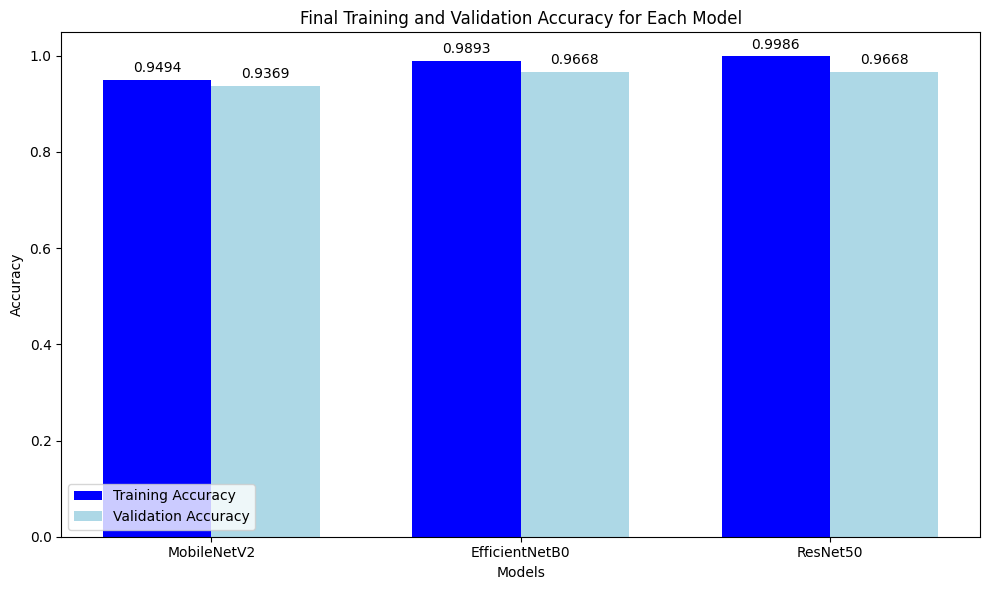

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Final accuracy for each model
final_train_acc = [train_acc_mobilenetv2[-1], train_acc_B0[-1], train_acc_resnet50[-1]]
final_val_acc = [val_acc_mobilenetv2[-1], val_acc_B0[-1], val_acc_resnet50[-1]]

# Model names
models = ['MobileNetV2', 'EfficientNetB0', 'ResNet50']

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Set positions of bars on x-axis
index = np.arange(len(models))

# Plot accuracy bars
train_bars = ax.bar(index - bar_width/2, final_train_acc, bar_width, label='Training Accuracy', color='blue')
val_bars = ax.bar(index + bar_width/2, final_val_acc, bar_width, label='Validation Accuracy', color='lightblue')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Final Training and Validation Accuracy for Each Model')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()

# Adding the values on top of the bars
for bar in train_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

for bar in val_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()



/Users/rajendarbore/Downloads/Yamini Project/PikachuVenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step - accuracy: 0.8975 - loss: 1.2944
---MobileNetV2---
Test Accuracy: 91.03%
Test Loss: 1.3008
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.9396 - loss: 0.1909
---EfficientNetB0---
Test Accuracy: 94.02%
Test Loss: 0.1929
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step - accuracy: 0.9627 - loss: 1.0333
---ResNet50---
Test Accuracy: 96.01%
Test Loss: 1.0372


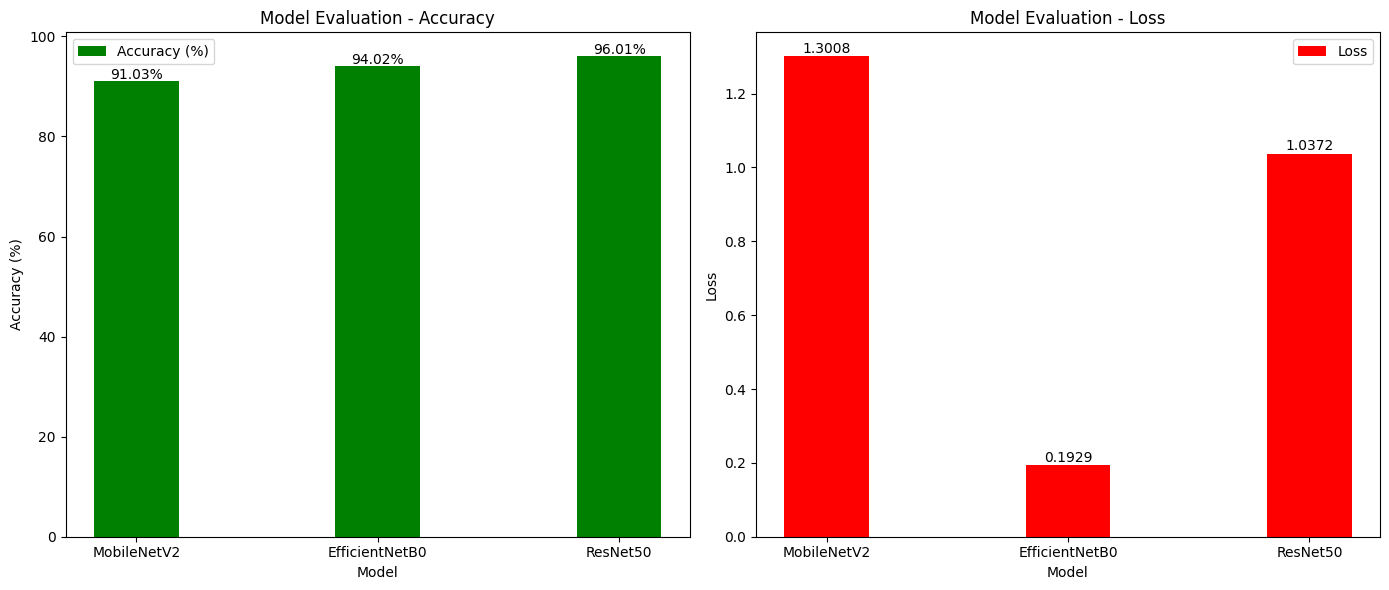

In [39]:
# Evaluate models
models = {
    "MobileNetV2": model_mob,
    "EfficientNetB0": model_eff,
    "ResNet50": model_ResNet50
}
generators = {
    "MobileNetV2": test_generator,
    "EfficientNetB0": test_generator_B0,
    "ResNet50": test_generator_50
}

model_names = []
accuracies = []
losses = []

for name in models:
    test_loss, test_accuracy = models[name].evaluate(generators[name], verbose=1)
    print(f"---{name}---")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    model_names.append(name)
    accuracies.append(test_accuracy * 100)  # Convert to %
    losses.append(test_loss)

# ---- SIDE-BY-SIDE BAR PLOTS ----
x = np.arange(len(model_names))
width = 0.35  # width of the bars

# Create a figure with two subplots (one for accuracy, one for loss)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
bars1 = ax1.bar(x, accuracies, width, label='Accuracy (%)', color='green')
ax1.set_title("Model Evaluation - Accuracy")
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()

# Add text labels for accuracy
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%", ha='center')

# Loss plot
bars2 = ax2.bar(x, losses, width, label='Loss', color='red')
ax2.set_title("Model Evaluation - Loss")
ax2.set_xlabel("Model")
ax2.set_ylabel("Loss")
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()

# Add text labels for loss
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.4f}", ha='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step
MobileNetV2 AUC (macro): 0.9987
EfficientNetB0 AUC (macro): 0.9993
ResNet50 AUC (macro): 0.9999


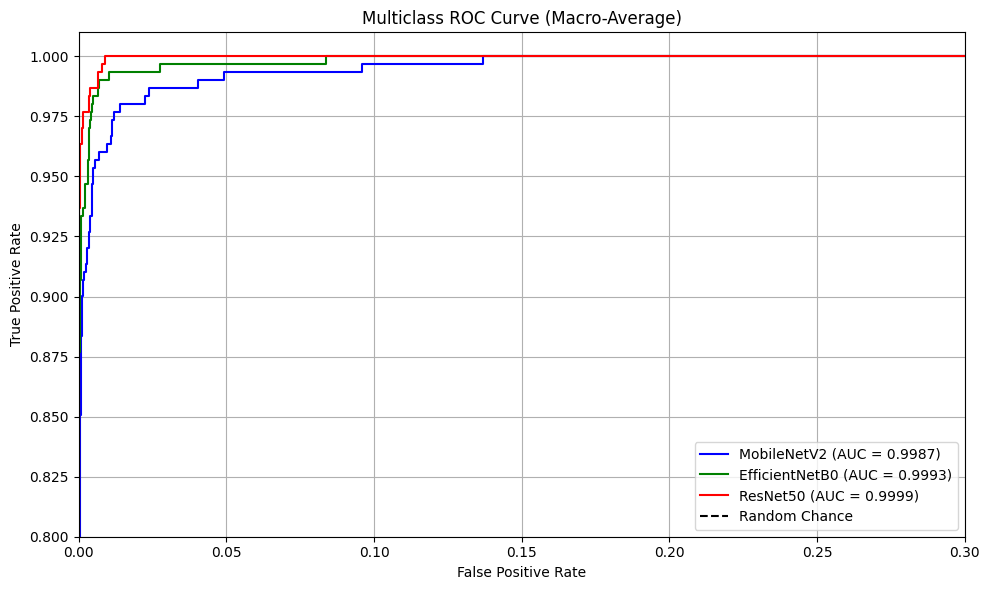

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Fix: Binarize true labels

y_pred_mob = model_mob.predict(test_generator, verbose=1)
y_pred_eff = model_eff.predict(test_generator_B0, verbose=1)
y_pred_res = model_ResNet50.predict(test_generator_50, verbose=1)

num_classes = y_pred_mob.shape[1]
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Compute macro-average ROC AUC scores
auc_mob = roc_auc_score(y_true, y_pred_mob, average="macro", multi_class="ovr")
auc_eff = roc_auc_score(y_true, y_pred_eff, average="macro", multi_class="ovr")
auc_res = roc_auc_score(y_true, y_pred_res, average="macro", multi_class="ovr")

print(f"MobileNetV2 AUC (macro): {auc_mob:.4f}")
print(f"EfficientNetB0 AUC (macro): {auc_eff:.4f}")
print(f"ResNet50 AUC (macro): {auc_res:.4f}")

# Plot macro-average ROC curves

fpr_mob, tpr_mob, _ = roc_curve(y_true_bin.ravel(), y_pred_mob.ravel())
fpr_eff, tpr_eff, _ = roc_curve(y_true_bin.ravel(), y_pred_eff.ravel())
fpr_res, tpr_res, _ = roc_curve(y_true_bin.ravel(), y_pred_res.ravel())

plt.figure(figsize=(10, 6))
plt.plot(fpr_mob, tpr_mob, label=f"MobileNetV2 (AUC = {auc_mob:.4f})", color='blue')
plt.plot(fpr_eff, tpr_eff, label=f"EfficientNetB0 (AUC = {auc_eff:.4f})", color='green')
plt.plot(fpr_res, tpr_res, label=f"ResNet50 (AUC = {auc_res:.4f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 0.3])  # Focus on low FPR region
plt.ylim([0.8, 1.01]) # Focus on high TPR region
plt.title("Multiclass ROC Curve (Macro-Average)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


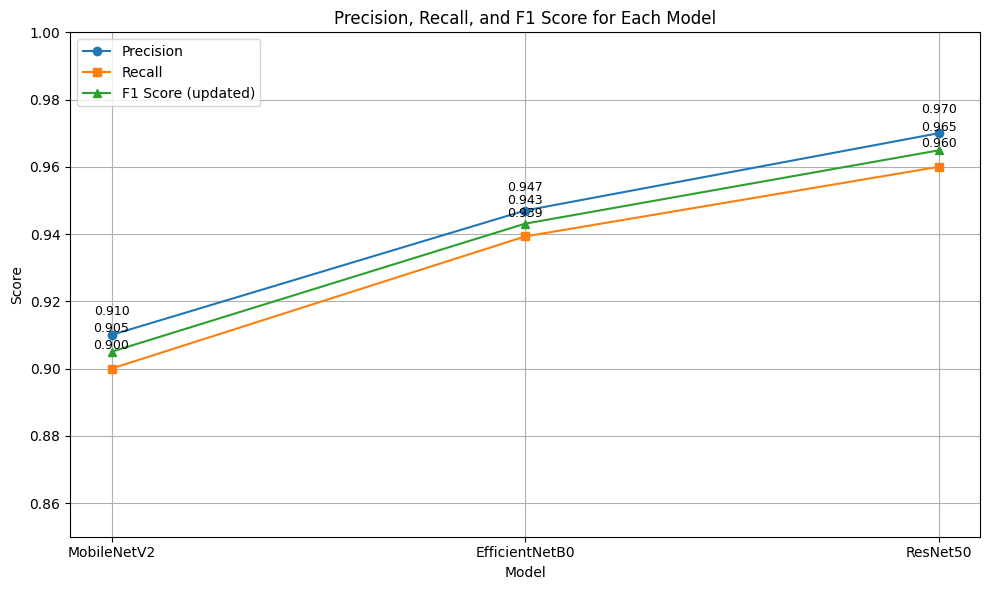

In [50]:
# Updated F1 scores with precise values
f1_score_updated = [0.905, 0.9431, 0.9649]

# Plotting again with updated F1 scores
plt.figure(figsize=(10, 6))
plt.plot(models, precision, marker='o', label='Precision')
plt.plot(models, recall, marker='s', label='Recall')
plt.plot(models, f1_score_updated, marker='^', label='F1 Score (updated)')

# Annotate each point with value
for i, model in enumerate(models):
    plt.text(model, precision[i] + 0.005, f"{precision[i]:.3f}", ha='center', va='bottom', fontsize=9)
    plt.text(model, recall[i] + 0.005, f"{recall[i]:.3f}", ha='center', va='bottom', fontsize=9)
    plt.text(model, f1_score_updated[i] + 0.005, f"{f1_score_updated[i]:.3f}", ha='center', va='bottom', fontsize=9)

# Axis labels and title
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score for Each Model")
plt.ylim(0.85, 1.00)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()
